In [1]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import scipy.stats as stats
import random
import glob
import os
import re

import utilities as ut
import modularised_utils as mut
from load_results import load_results, list_available_results


from matplotlib.animation import FuncAnimation
from IPython.display import HTML

sns.set_theme(style="whitegrid")
seed = 42
np.random.seed(seed)

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.


In [2]:
label_map_empirical = {
                        'DIROCA (eps_0.107_delta_0.035)': 'DiRoCA_star',
                        'DIROCA (eps_1.0_delta_1.0)': 'DIROCA_1',
                        'DIROCA (eps_2.0_delta_2.0)': 'DIROCA_2',
                        'DIROCA (eps_4.0_delta_4.0)': 'DIROCA_4',
                        'DIROCA (eps_8.0_delta_8.0)': 'DIROCA_8',
                        'GradCA': 'GradCA',
                        'BARYCA': 'BARYCA',
                        'Abs-LiNGAM (Perfect)': 'Abslin_p',
                        'Abs-LiNGAM (Noisy)': 'Abslin_n'
                    }
label_map_gaussian = {
                        'DIROCA (eps_delta_0.111)': 'DiRoCA_star',
                        'DIROCA (eps_delta_1)': 'DIROCA_1',
                        'DIROCA (eps_delta_2)': 'DIROCA_2',
                        'DIROCA (eps_delta_4)': 'DIROCA_4',
                        'DIROCA (eps_delta_8)': 'DIROCA_8',
                        'GradCA': 'GradCA',
                        'BARYCA': 'BARYCA'
                    }

print_label_map  = {
                        'DiRoCA_star':  r'DiRoCA$_{\epsilon_\ell^*, \epsilon_h^*}$',
                        'DIROCA_1':     r'DiRoCA$_{1,1}$',
                        'DIROCA_2':     r'DiRoCA$_{2,2}$',
                        'DIROCA_4':     r'DiRoCA$_{4,4}$',
                        'DIROCA_8':     r'DiRoCA$_{8,8}$',
                        'GradCA':       r'GRAD$_{(\tau, \omega)}$',
                        'BARYCA':       r'BARY$_{(\tau, \omega)}$',
                        'Abslin_p':     r'AbsLin$_{\text{p}}$', 
                        'Abslin_n':     r'AbsLin$_{\text{n}}$'
                    }

### Fix σ, vary α

In [3]:

# plt.rcParams.update({
#     "text.usetex": False,                 
#     "font.family": "serif",
#     "font.serif": ["Computer Modern Roman", "CMU Serif", "DejaVu Serif"],
#     "mathtext.fontset": "cm",             # CM-style math
#     "mathtext.rm": "serif"
# })

# # Methods and display labels
# methods_to_plot = [
#     'DiRoCA_star', 'DIROCA_2', 'GradCA', 'BARYCA', 'Abslin_p', 'Abslin_n'
# ]
# display_names = [print_label_map[m] for m in methods_to_plot]

# # Color palette (colorblind-friendly)
# palette_colors = sns.color_palette('colorblind', n_colors=len(display_names))
# color_map = dict(zip(display_names, palette_colors))
# color_map = {
#     r'DiRoCA$_{\epsilon_\ell^*, \epsilon_h^*}$': '#1f77b4', 
#     r'DiRoCA$_{2,2}$': 'darkorange',                            
#     r'GRAD$_{(\tau, \omega)}$': '#2ca02c',                  
#     r'BARY$_{(\tau, \omega)}$': '#d62728',                     
#     r'AbsLin$_{\text{p}}$': '#9467bd',                       
#     r'AbsLin$_{\text{n}}$': '#8c564b'                       
# }
# # Fixed noise levels per dataset
# noise_level_to_plot = {
#     'slc': 5.0,
#     'lilucas': 10.0
# }

# # Loop through datasets
# for experiment in ['slc', 'lilucas']:
#     fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=False)
#     combined_handles = {}

#     for i, noise_type in enumerate(['gaussian', 'empirical']):
#         all_data = ut.load_all_data(experiment)

#         df = load_results(
#             experiment=experiment,
#             evaluation_type=noise_type,
#             shift_type='additive',
#             distribution='student-t',
#             alpha_steps=10,
#             alpha_min=0.0,
#             alpha_max=1.0,
#             noise_steps=20,
#             noise_min=0.0,
#             noise_max=noise_level_to_plot[experiment],
#             trials=20,
#             zero_mean=True
#         )

#         # Check if data was loaded successfully
#         if df is None:
#             print(f"No data found for {noise_type} in {experiment}")
#             continue

#         # Replace method names
#         if noise_type == 'empirical':
#             df['method'] = df['method'].replace(label_map_empirical)
#         else:
#             df['method'] = df['method'].replace(label_map_gaussian)

#         # Filter subset
#         df = df[
#             (df['noise_scale'] == noise_level_to_plot[experiment]) &
#             (df['method'].isin(methods_to_plot))
#         ].copy()

#         if df.empty:
#             print(f"No data for {noise_type} in {experiment}")
#             continue

#         df['display_name'] = df['method'].map(print_label_map)

#         ax = axes[i]
#         sns.lineplot(
#             data=df,
#             x='alpha',
#             y='error',
#             hue='display_name',
#             hue_order=display_names,
#             palette=color_map,
#             marker='o',
#             linewidth=2.5,
#             markersize=8,
#             errorbar='sd',
#             ax=ax,
#             legend=False
#         )

#         ax.set_title(f"{noise_type.capitalize()}", fontsize=30)
#         ax.set_xlabel(r'$\alpha$', fontsize=34)
#         if i == 0:
#             ax.set_ylabel('Abstraction Error', fontsize=32)
#         else:
#             ax.set_ylabel('')

#         ax.tick_params(axis='both', labelsize=18)
#         ax.grid(True, linestyle='--', alpha=0.7)

#         # Collect handles
#         handles, labels = ax.get_legend_handles_labels()
#         for h, l in zip(handles, labels):
#             if l not in combined_handles:
#                 combined_handles[l] = h

#     # Legend with all methods
#     ordered_handles = [
#         combined_handles.get(lbl, plt.Line2D([], [], color=color_map[lbl], linestyle='-', linewidth=6, label=lbl))
#         for lbl in display_names
#     ]

#     fig.legend(ordered_handles, display_names,
#                loc='lower center', ncol=6, fontsize=20, frameon=False)

#     fig.tight_layout(rect=[0, 0.08, 1, 1])
#     plt.savefig(f"plots/abstraction_vs_alpha_{experiment}_solidlines.png", dpi=300, bbox_inches='tight')
#     plt.show()


Data loaded for 'slc'.
Loading: evaluation_additive_student-t_alpha10-0.0-1.0_noise20-0.0-5.0_trials20_zero_meanTrue_20251001_113124.csv
Parameters: gaussian additive student-t, α: 10 steps (0.0-1.0), noise: 20 steps (0.0-5.0), trials: 20, zero_mean: True
Data loaded for 'slc'.
Loading: empirical_evaluation_additive_student-t_alpha10-0.0-1.0_noise20-0.0-5.0_trials20_zero_meanTrue_20250930_191641.csv
Parameters: empirical additive student-t, α: 10 steps (0.0-1.0), noise: 20 steps (0.0-5.0), trials: 20, zero_mean: True
Data loaded for 'lilucas'.
Loading: evaluation_additive_student-t_alpha10-0.0-1.0_noise20-0.0-10.0_trials20_zero_meanTrue_20251001_135935.csv
Parameters: gaussian additive student-t, α: 10 steps (0.0-1.0), noise: 20 steps (0.0-10.0), trials: 20, zero_mean: True
Data loaded for 'lilucas'.
Loading: empirical_evaluation_additive_student-t_alpha10-0.0-1.0_noise20-0.0-10.0_trials20_zero_meanTrue_20250930_205000.csv
Parameters: empirical additive student-t, α: 10 steps (0.0-1.0)

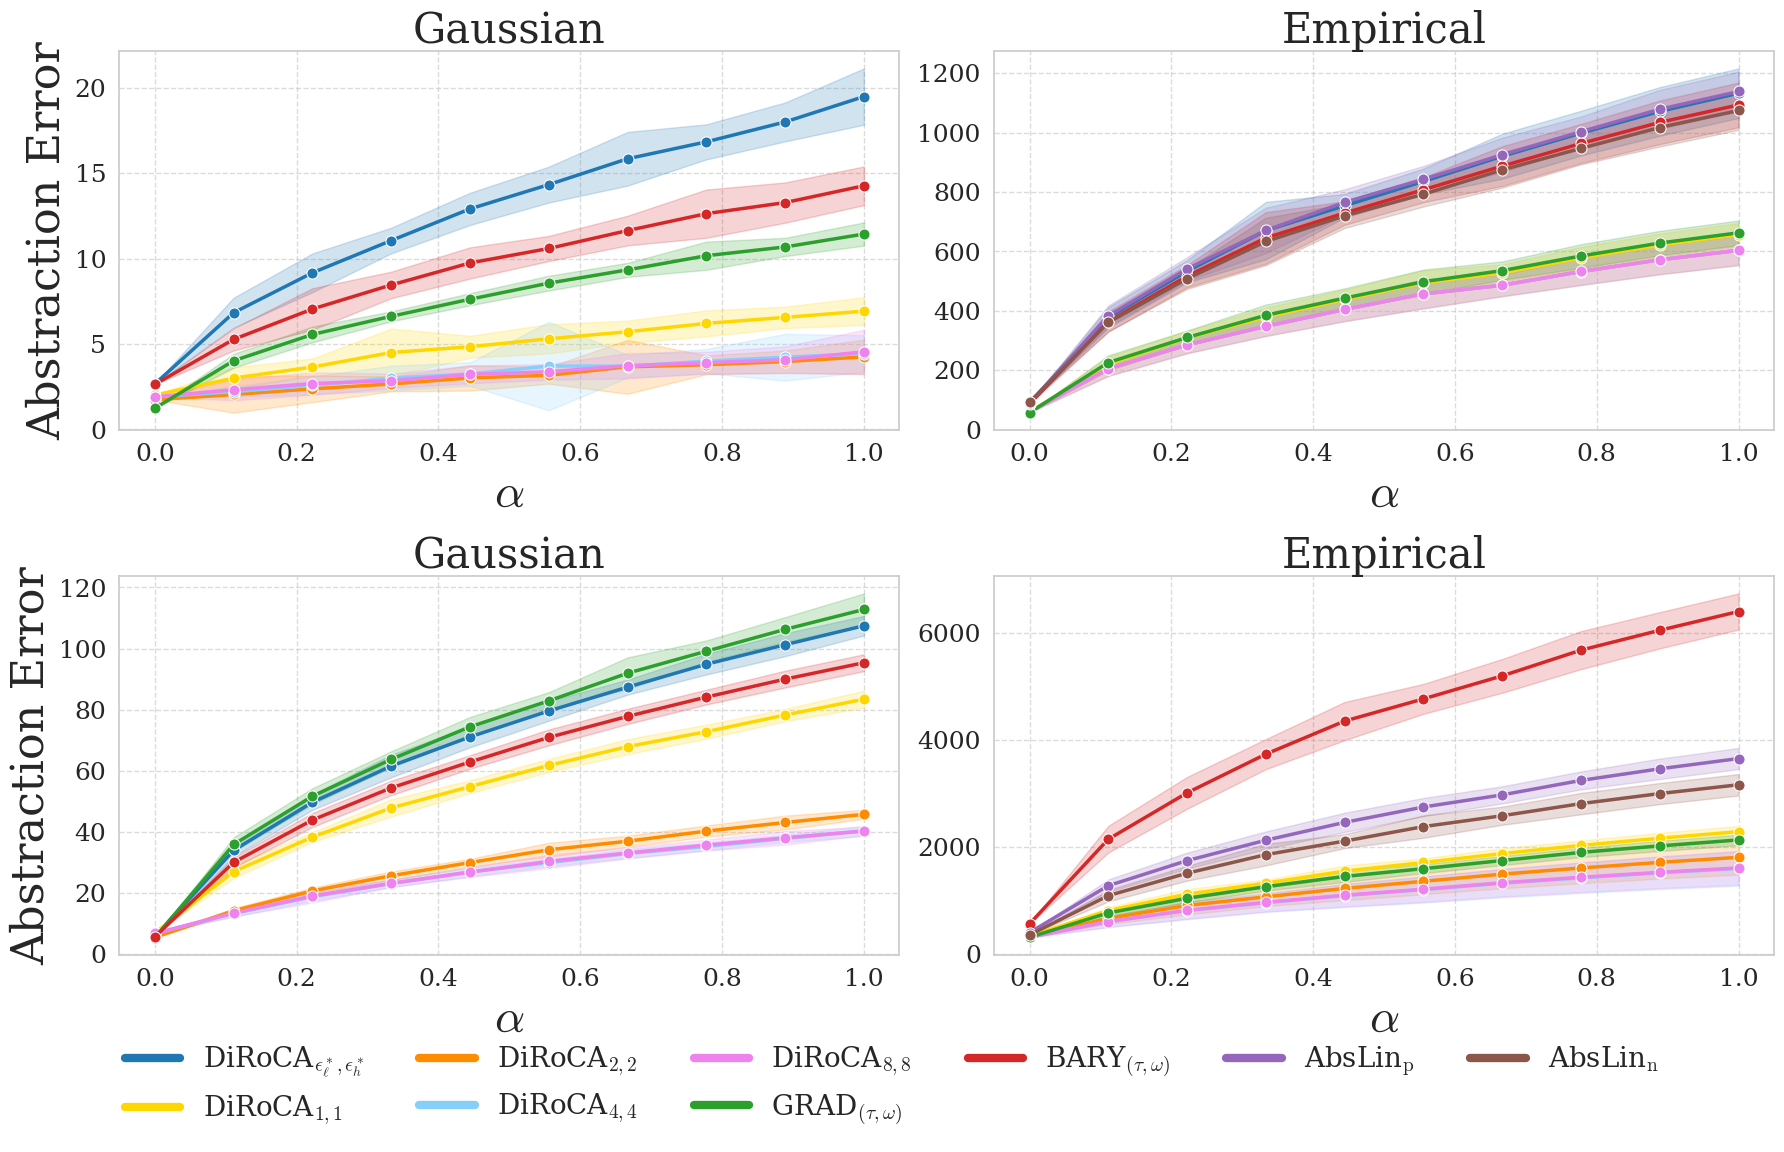

In [ ]:
plt.rcParams.update({
    "text.usetex": False,                 
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman", "CMU Serif", "DejaVu Serif"],
    "mathtext.fontset": "cm",             # CM-style math
    "mathtext.rm": "serif"
})

# Methods and display labels
methods_to_plot = [
    'DiRoCA_star', 'DIROCA_1', 'DIROCA_2', 'DIROCA_4', 'DIROCA_8', 'GradCA', 'BARYCA', 'Abslin_p', 'Abslin_n'
]
display_names = [print_label_map[m] for m in methods_to_plot]

# Color palette (colorblind-friendly)
palette_colors = sns.color_palette('colorblind', n_colors=len(display_names))
color_map = dict(zip(display_names, palette_colors))
color_map = {
    r'DiRoCA$_{\epsilon_\ell^*, \epsilon_h^*}$': '#1f77b4', 
    r'DiRoCA$_{1,1}$': 'gold',
    r'DiRoCA$_{2,2}$': 'darkorange',
    r'DiRoCA$_{4,4}$': 'lightskyblue',
    r'DiRoCA$_{8,8}$': 'violet',
    r'GRAD$_{(\tau, \omega)}$': '#2ca02c',                  
    r'BARY$_{(\tau, \omega)}$': '#d62728',                     
    r'AbsLin$_{\text{p}}$': '#9467bd',                       
    r'AbsLin$_{\text{n}}$': '#8c564b'                       
}
# Fixed noise levels per dataset
noise_level_to_plot = {
    'slc': 5.0,
    'lilucas': 10.0
}
# rcParams, label maps, methods_to_plot, display_names, color_map, noise_level_to_plot
# are assumed to be exactly as in your snippet above.

fig, axes = plt.subplots(2, 2, figsize=(18, 12), sharey=False)
fig.subplots_adjust(hspace=0.4)
# Define panels: ((row, col), experiment, noise_type, panel title)
panels = [
    ((0, 0), 'slc',     'gaussian',  "Gaussian"),
    ((0, 1), 'slc',     'empirical', "Empirical"),
    ((1, 0), 'lilucas', 'gaussian',  "Gaussian"),
    ((1, 1), 'lilucas', 'empirical', "Empirical"),
]

combined_handles = {}  # collect handles from all subplots (for a single legend)
present_display_names_global = set()
for (r, c), experiment, noise_type, title_str in panels:
    ax = axes[r, c]

    # Load per-panel data
    all_data = ut.load_all_data(experiment)
    df = load_results(
        experiment=experiment,
        evaluation_type=noise_type,
        shift_type='additive',
        distribution='student-t', #'gaussian', #'student-t',
        alpha_steps=10,
        alpha_min=0.0,
        alpha_max=1.0,
        noise_steps=20,
        noise_min=0.0,
        noise_max=noise_level_to_plot[experiment],
        trials=20,
        zero_mean=True
    )

    if df is None:
        print(f"No data found for {noise_type} in {experiment}")
        # still style the empty axes
        ax.set_title(title_str, fontsize=30)
        ax.set_xlabel(r'$\alpha$', fontsize=34)
        ax.set_ylabel('Abstraction Error' if c == 0 else '', fontsize=32)
        ax.tick_params(axis='both', labelsize=18)
        ax.grid(True, linestyle='--', alpha=0.7)
        continue

    # Replace method names
    if noise_type == 'empirical':
        df['method'] = df['method'].replace(label_map_empirical)
    else:
        df['method'] = df['method'].replace(label_map_gaussian)

    # Filter subset
    df = df[
        (df['noise_scale'] == noise_level_to_plot[experiment]) &
        (df['method'].isin(methods_to_plot))
    ].copy()

    if df.empty:
        print(f"No data for {noise_type} in {experiment}")
        ax.set_title(title_str, fontsize=30)
        ax.set_xlabel(r'$\alpha$', fontsize=34)
        ax.set_ylabel('Abstraction Error' if c == 0 else '', fontsize=32)
        ax.tick_params(axis='both', labelsize=18)
        ax.grid(True, linestyle='--', alpha=0.7)
        continue

    df['display_name'] = df['method'].map(print_label_map)

    # Keep legend unified: hide per-axes legend, but keep consistent order
    sns.lineplot(
        data=df,
        x='alpha',
        y='error',
        hue='display_name',
        hue_order=display_names,
        palette=color_map,
        marker='o',
        linewidth=2.5,
        markersize=8,
        errorbar='sd',
        ax=ax,
        legend=False
    )
    present_display_names_global.update(df['display_name'].unique())

    ax.set_title(title_str, fontsize=30)
    ax.set_xlabel(r'$\alpha$', fontsize=34)
    ax.set_ylabel('Abstraction Error' if c == 0 else '', fontsize=32)
    ax.tick_params(axis='both', labelsize=18)
    ax.grid(True, linestyle='--', alpha=0.7)

    # Collect handles actually present in this subplot
    handles, labels = ax.get_legend_handles_labels()
    for h, l in zip(handles, labels):
        if l and (l not in combined_handles):
            combined_handles[l] = h

# Build unified legend from data-driven present labels
present_display_names_ordered = [lbl for lbl in display_names if lbl in present_display_names_global]

if present_display_names_ordered:
    ordered_handles = [
        plt.Line2D([], [], linestyle='-', linewidth=6,
                   label=lbl, color=color_map.get(lbl, '#000000'))
        for lbl in present_display_names_ordered
    ]
    fig.legend(
        ordered_handles,
        present_display_names_ordered,
        loc='lower center',
        ncol=min(6, len(present_display_names_ordered)),
        fontsize=20,
        frameon=False
    )
else:
    print("No legend entries found across panels; skipping legend.")


# Optional: global title
# fig.suptitle("Abstraction Error vs $\\alpha$", fontsize=34, y=0.98)

# Leave space at bottom for the single legend
fig.tight_layout(rect=[0, 0.08, 1, 0.97])
plt.savefig("plots/abstraction_vs_alpha_SLC_LiLuCas_2x2.png", dpi=300, bbox_inches='tight')
plt.show()


### Fix α, vary σ

Data loaded for 'slc'.
Loading: evaluation_additive_gaussian_alpha10-0.0-1.0_noise20-0.0-5.0_trials20_zero_meanTrue_20251001_111213.csv
Parameters: gaussian additive gaussian, α: 10 steps (0.0-1.0), noise: 20 steps (0.0-5.0), trials: 20, zero_mean: True
Data loaded for 'slc'.
Loading: empirical_evaluation_additive_gaussian_alpha10-0.0-1.0_noise20-0.0-5.0_trials20_zero_meanTrue_20250930_190346.csv
Parameters: empirical additive gaussian, α: 10 steps (0.0-1.0), noise: 20 steps (0.0-5.0), trials: 20, zero_mean: True
Data loaded for 'lilucas'.
Loading: evaluation_additive_gaussian_alpha10-0.0-1.0_noise20-0.0-10.0_trials20_zero_meanTrue_20251001_124453.csv
Parameters: gaussian additive gaussian, α: 10 steps (0.0-1.0), noise: 20 steps (0.0-10.0), trials: 20, zero_mean: True
Data loaded for 'lilucas'.
Loading: empirical_evaluation_additive_gaussian_alpha10-0.0-1.0_noise20-0.0-10.0_trials20_zero_meanTrue_20250930_200124.csv
Parameters: empirical additive gaussian, α: 10 steps (0.0-1.0), noise:

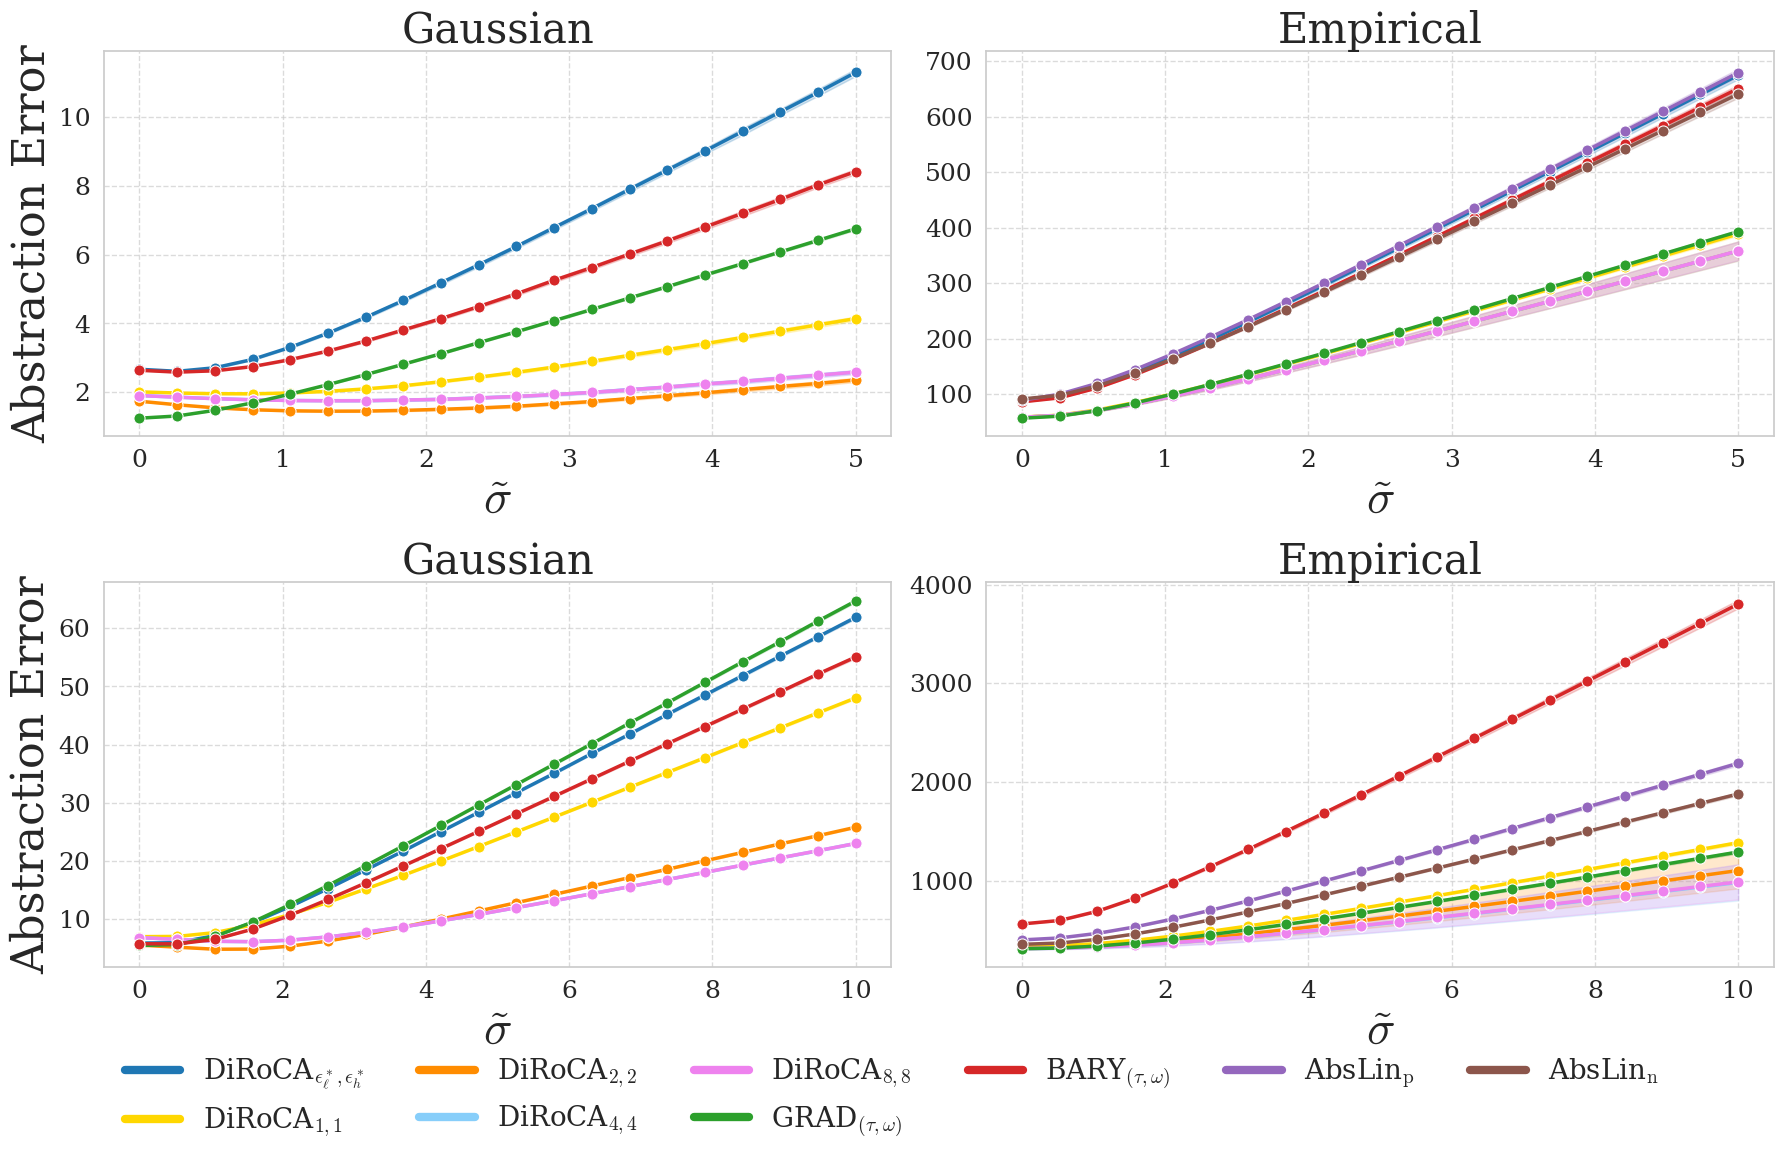

In [25]:
# --- Unified 2x2 figure with single legend for noise-sweeps at fixed alpha ---

# Assumes: rcParams, print_label_map, label_map_gaussian, label_map_empirical,
# methods_to_plot, display_names, color_map are defined exactly as in your snippet.

fixed_alpha_to_plot = {'slc': 1.0, 'lilucas': 1.0}
noise_level_to_plot = {'slc': 5.0, 'lilucas': 10.0}  # for load_results noise_max

fig, axes = plt.subplots(2, 2, figsize=(18, 12), sharey=False)
fig.subplots_adjust(hspace=0.4)

# Panels: ((row, col), experiment, noise_type, panel title)
panels = [
    ((0, 0), 'slc',     'gaussian',  "Gaussian"),
    ((0, 1), 'slc',     'empirical', "Empirical"),
    ((1, 0), 'lilucas', 'gaussian',  "Gaussian"),
    ((1, 1), 'lilucas', 'empirical', "Empirical"),
]

present_display_names_global = set()

for (r, c), experiment, noise_type, title_str in panels:
    ax = axes[r, c]

    # Load results for this panel
    all_data = ut.load_all_data(experiment)
    df = load_results(
        experiment=experiment,
        evaluation_type=noise_type,
        shift_type='additive',
        distribution='gaussian', #'gaussian', #'student-t',
        alpha_steps=10,
        alpha_min=0.0,
        alpha_max=1.0,
        noise_steps=20,
        noise_min=0.0,
        noise_max=noise_level_to_plot[experiment],
        trials=20,
        zero_mean=True
    )

    if df is None:
        print(f"No data found for {noise_type} in {experiment}")
        ax.set_title(title_str, fontsize=30)
        ax.set_xlabel(r'$\tilde{\sigma}$', fontsize=34)
        ax.set_ylabel('Abstraction Error' if c == 0 else '', fontsize=32)
        ax.tick_params(axis='both', labelsize=18)
        ax.grid(True, linestyle='--', alpha=0.7)
        continue

    # Normalize method labels
    if noise_type == 'empirical':
        df['method'] = df['method'].replace(label_map_empirical)
    else:
        df['method'] = df['method'].replace(label_map_gaussian)

    # Filter: fixed alpha and desired methods
    df = df[
        (np.abs(df['alpha'] - fixed_alpha_to_plot[experiment]) < 1e-4) &
        (df['method'].isin(methods_to_plot))
    ].copy()

    if df.empty:
        print(f"No data for {noise_type} in {experiment} at alpha={fixed_alpha_to_plot[experiment]}")
        ax.set_title(title_str, fontsize=30)
        ax.set_xlabel(r'$\tilde{\sigma}$', fontsize=34)
        ax.set_ylabel('Abstraction Error' if c == 0 else '', fontsize=32)
        ax.tick_params(axis='both', labelsize=18)
        ax.grid(True, linestyle='--', alpha=0.7)
        continue

    df['display_name'] = df['method'].map(print_label_map)

    # Plot (no per-axes legend)
    sns.lineplot(
        data=df,
        x='noise_scale',
        y='error',
        hue='display_name',
        hue_order=display_names,
        palette=color_map,
        marker='o',
        linewidth=2.5,
        markersize=8,
        errorbar='sd',
        ax=ax,
        legend=False
    )
    present_display_names_global.update(df['display_name'].unique())

    ax.set_title(title_str, fontsize=30)
    ax.set_xlabel(r'$\tilde{\sigma}$', fontsize=34)
    ax.set_ylabel('Abstraction Error' if c == 0 else '', fontsize=32)
    ax.tick_params(axis='both', labelsize=18)
    ax.grid(True, linestyle='--', alpha=0.7)

# --- Unified legend driven by present labels ---
present_display_names_ordered = [lbl for lbl in display_names if lbl in present_display_names_global]

if present_display_names_ordered:
    ordered_handles = [
        plt.Line2D([], [], linestyle='-', linewidth=6,
                   label=lbl, color=color_map.get(lbl, '#000000'))
        for lbl in present_display_names_ordered
    ]
    fig.legend(
        ordered_handles,
        present_display_names_ordered,
        loc='lower center',
        ncol=min(6, len(present_display_names_ordered)),
        fontsize=20,
        frameon=False
    )
else:
    print("No legend entries found across panels; skipping legend.")

# Space for legend and a bit more gap between rows
fig.tight_layout(rect=[0, 0.08, 1, 0.98])
plt.savefig("plots/abstraction_vs_noise_SLC_LiLuCas_alpha_fixed_2x2.png", dpi=300, bbox_inches='tight')
plt.show()


Data loaded for 'slc'.
Loading: evaluation_additive_student-t_alpha10-0.0-1.0_noise20-0.0-5.0_trials20_zero_meanTrue_20251001_113124.csv
Parameters: gaussian additive student-t, α: 10 steps (0.0-1.0), noise: 20 steps (0.0-5.0), trials: 20, zero_mean: True
Data loaded for 'slc'.
Loading: empirical_evaluation_additive_student-t_alpha10-0.0-1.0_noise20-0.0-5.0_trials20_zero_meanTrue_20250930_191641.csv
Parameters: empirical additive student-t, α: 10 steps (0.0-1.0), noise: 20 steps (0.0-5.0), trials: 20, zero_mean: True


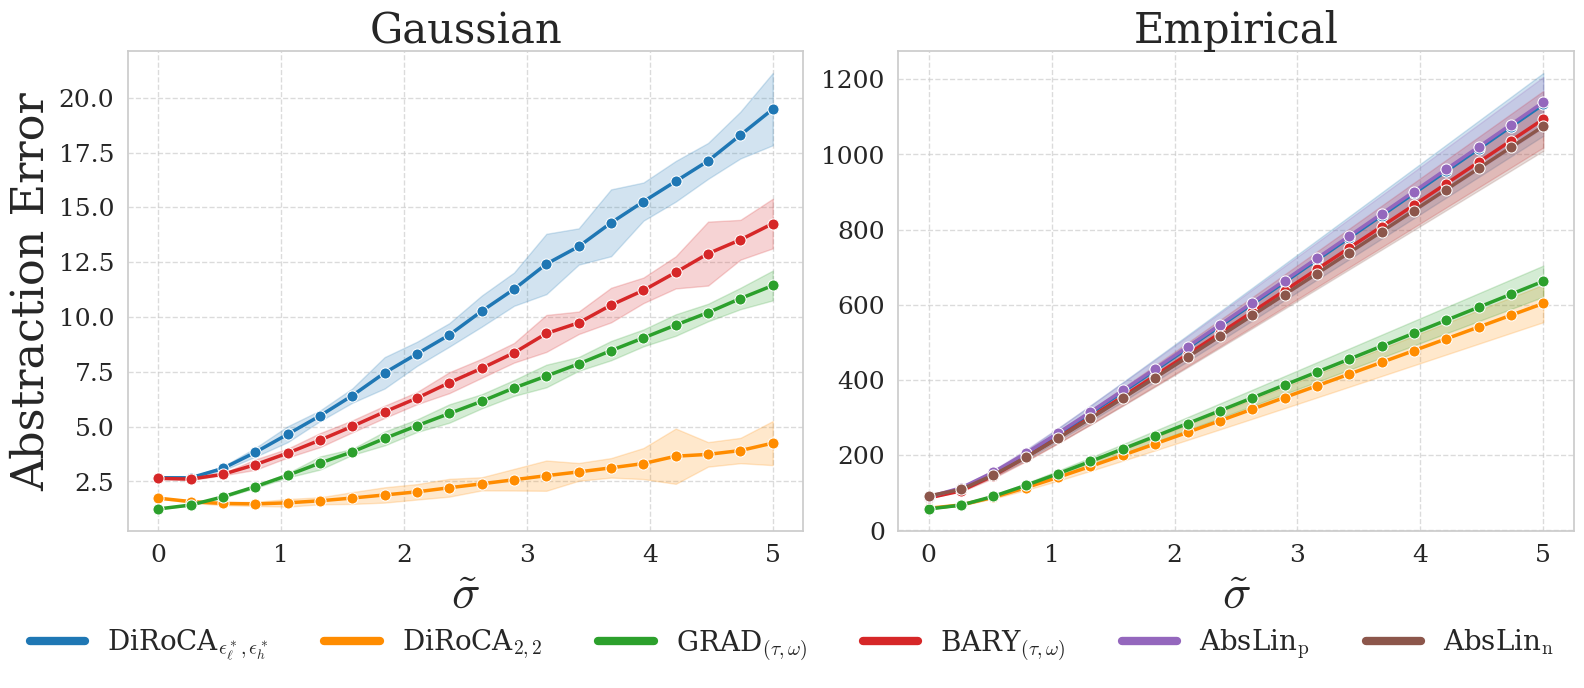

Data loaded for 'lilucas'.
Loading: evaluation_additive_student-t_alpha10-0.0-1.0_noise20-0.0-10.0_trials20_zero_meanTrue_20251001_135935.csv
Parameters: gaussian additive student-t, α: 10 steps (0.0-1.0), noise: 20 steps (0.0-10.0), trials: 20, zero_mean: True
Data loaded for 'lilucas'.
Loading: empirical_evaluation_additive_student-t_alpha10-0.0-1.0_noise20-0.0-10.0_trials20_zero_meanTrue_20250930_205000.csv
Parameters: empirical additive student-t, α: 10 steps (0.0-1.0), noise: 20 steps (0.0-10.0), trials: 20, zero_mean: True


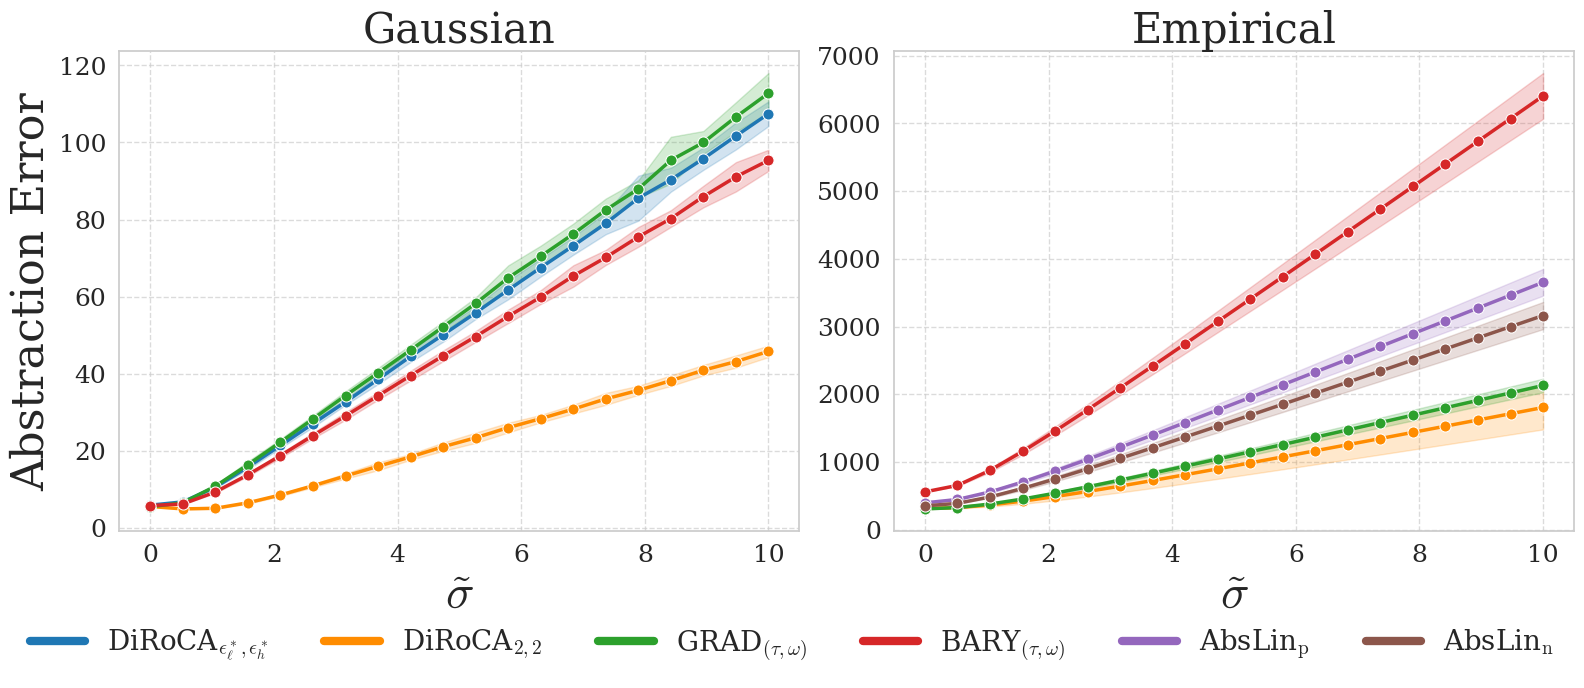

In [ ]:
# plt.rcParams.update({
#     "text.usetex": False,                 
#     "font.family": "serif",
#     "font.serif": ["Computer Modern Roman", "CMU Serif", "DejaVu Serif"],
#     "mathtext.fontset": "cm",             # CM-style math
#     "mathtext.rm": "serif"
# })

# # Method sets and display labels
# methods_to_plot = [
#     'DiRoCA_star', 'DIROCA_2', 'GradCA', 'BARYCA', 'Abslin_p', 'Abslin_n'
# ]
# display_names = [print_label_map[m] for m in methods_to_plot]

# # Color map
# color_map = {
#     r'DiRoCA$_{\epsilon_\ell^*, \epsilon_h^*}$': '#1f77b4',
#     r'DiRoCA$_{2,2}$': 'darkorange',
#     r'GRAD$_{(\tau, \omega)}$': '#2ca02c',
#     r'BARY$_{(\tau, \omega)}$': '#d62728',
#     r'AbsLin$_{\text{p}}$': '#9467bd',
#     r'AbsLin$_{\text{n}}$': '#8c564b'
# }

# # Fixed alpha values
# fixed_alpha_to_plot = {
#     'slc': 1.0,
#     'lilucas': 1.0
# }

# # Main loop
# for experiment in ['slc', 'lilucas']:
#     fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=False)
#     combined_handles = {}

#     for i, noise_type in enumerate(['gaussian', 'empirical']):
#         all_data = ut.load_all_data(experiment)

#         df = load_results(
#             experiment=experiment,
#             evaluation_type=noise_type,
#             shift_type='additive',
#             distribution='student-t',
#             alpha_steps=10,
#             alpha_min=0.0,
#             alpha_max=1.0,
#             noise_steps=20,
#             noise_min=0.0,
#             noise_max=5.0 if experiment == 'slc' else 10.0,
#             trials=20,
#             zero_mean=True
#         )

#         if noise_type == 'empirical':
#             df['method'] = df['method'].replace(label_map_empirical)
#         else:
#             df['method'] = df['method'].replace(label_map_gaussian)

#         df = df[
#             (np.abs(df['alpha'] - fixed_alpha_to_plot[experiment]) < 1e-4) &
#             (df['method'].isin(methods_to_plot))
#         ].copy()

#         if df.empty:
#             print(f"No data for {noise_type} in {experiment}")
#             continue

#         df['display_name'] = df['method'].map(print_label_map)

#         ax = axes[i]
#         sns.lineplot(
#             data=df,
#             x='noise_scale',
#             y='error',
#             hue='display_name',
#             hue_order=display_names,
#             palette=color_map,
#             marker='o',
#             linewidth=2.5,
#             markersize=8,
#             errorbar='sd',
#             ax=ax,
#             legend=False
#         )

#         ax.set_title(f"{noise_type.capitalize()}", fontsize=30)
#         ax.set_xlabel(r'$\tilde{\sigma}$', fontsize=34)
#         if i == 0:
#             ax.set_ylabel('Abstraction Error', fontsize=32)
#         else:
#             ax.set_ylabel('')

#         ax.tick_params(axis='both', labelsize=18)
#         ax.grid(True, linestyle='--', alpha=0.7)

#         # Gather handles
#         handles, labels = ax.get_legend_handles_labels()
#         for h, l in zip(handles, labels):
#             if l not in combined_handles:
#                 combined_handles[l] = h

#     # Bottom legend
#     ordered_handles = [
#         combined_handles.get(lbl, plt.Line2D([], [], color=color_map[lbl], linestyle='-', linewidth=6, label=lbl))
#         for lbl in display_names
#     ]

#     fig.legend(ordered_handles, display_names,
#                loc='lower center', ncol=6, fontsize=20, frameon=False)

#     fig.tight_layout(rect=[0, 0.08, 1, 1])
#     plt.savefig(f"plots/abstraction_vs_noise_{experiment}_alpha_fixed.png", dpi=300, bbox_inches='tight')
#     plt.show()


### Work on a particular setting/example

In [103]:
experiment      = 'slc'
evaluation_type = 'gaussian'

path = f"data/{experiment}/results"
saved_folds = joblib.load(f"data/{experiment}/cv_folds.pkl")

all_data      = ut.load_all_data(experiment)

Dll_samples   = all_data['LLmodel']['data']
Dhl_samples   = all_data['HLmodel']['data']
I_ll_relevant = all_data['LLmodel']['intervention_set']
omega         = all_data['abstraction_data']['omega']
ll_var_names  = list(all_data['LLmodel']['graph'].nodes())
hl_var_names  = list(all_data['HLmodel']['graph'].nodes())

Data loaded for 'slc'.


In [104]:
final_results_df = load_results(
                                experiment=experiment,
                                evaluation_type=evaluation_type,
                                shift_type='additive',
                                distribution='gaussian',
                                alpha_steps=10,
                                alpha_min=0.0,
                                alpha_max=1.0,
                                noise_steps=20,
                                noise_min=0.0,
                                noise_max=5.0 if experiment == 'slc' else 10.0,
                                trials=20,
                                zero_mean=True
                            )


Loading: evaluation_additive_gaussian_alpha10-0.0-1.0_noise20-0.0-5.0_trials20_zero_meanTrue_20251001_111213.csv
Parameters: gaussian additive gaussian, α: 10 steps (0.0-1.0), noise: 20 steps (0.0-5.0), trials: 20, zero_mean: True


### 0-shift (α=0)

In [105]:
df_clean             = final_results_df[final_results_df['alpha']==0.0]
summary_stats        = df_clean.groupby(['method'])['error'].agg(['mean', 'std', 'count'])
summary_stats['sem'] = summary_stats['std']# / np.sqrt(summary_stats['count'])

print("--- Final Summary (Mean Error ± SEM) ---")

print("\n" + "="*65)
print(f"{'Method/Run':<45} | {'Mean ± Std'}")
print("="*65)

for method_name, row in summary_stats.iterrows():
    mean_val = row['mean']
    sem_val = row['sem']
    
    print(f"{method_name:<45} | {mean_val:>7.4f} ± {sem_val:.4f}")

print("="*65)

--- Final Summary (Mean Error ± SEM) ---

Method/Run                                    | Mean ± Std
BARYCA                                        |  2.6382 ± 0.0036
DIROCA (eps_delta_0.111)                      |  2.6674 ± 0.0170
DIROCA (eps_delta_1)                          |  2.0116 ± 0.0075
DIROCA (eps_delta_2)                          |  1.7386 ± 0.0083
DIROCA (eps_delta_4)                          |  1.9038 ± 0.0078
DIROCA (eps_delta_8)                          |  1.9038 ± 0.0078
GradCA                                        |  1.2455 ± 0.0055


In [106]:
# Paired t-tests to compare best method vs others
from scipy.stats import ttest_rel
import warnings
warnings.filterwarnings('ignore')

# Get the best method (lowest mean error)
best_method = summary_stats['mean'].idxmin()
best_mean = summary_stats.loc[best_method, 'mean']

print(f"\nBest method: {best_method} (mean error: {best_mean:.4f})")
print("\nPaired t-tests (best vs others):")
print("="*60)

# Get data for best method
best_data = df_clean[df_clean['method'] == best_method]['error'].values

# Compare against all other methods
for method in summary_stats.index:
    if method != best_method:
        other_data = df_clean[df_clean['method'] == method]['error'].values
        
        # Ensure same number of observations for paired test
        min_len = min(len(best_data), len(other_data))
        if min_len > 0:
            t_stat, p_value = ttest_rel(best_data[:min_len], other_data[:min_len])
            other_mean = summary_stats.loc[method, 'mean']
            diff = best_mean - other_mean
            
            print(f"{best_method} vs {method:<30} | p={p_value:.4f} | diff={diff:.4f} | {'Significant' if p_value < 0.05 else 'Not significant'}")
        else:
            print(f"{best_method} vs {method:<30} | No data available")



Best method: GradCA (mean error: 1.2455)

Paired t-tests (best vs others):
GradCA vs BARYCA                         | p=0.0000 | diff=-1.3927 | Significant
GradCA vs DIROCA (eps_delta_0.111)       | p=0.0000 | diff=-1.4219 | Significant
GradCA vs DIROCA (eps_delta_1)           | p=0.0000 | diff=-0.7661 | Significant
GradCA vs DIROCA (eps_delta_2)           | p=0.0000 | diff=-0.4931 | Significant
GradCA vs DIROCA (eps_delta_4)           | p=0.0000 | diff=-0.6583 | Significant
GradCA vs DIROCA (eps_delta_8)           | p=0.0000 | diff=-0.6583 | Significant


### ρ-shift (α=1, σ>0)

In [107]:
alpha_point = 1.0
noise_level_point = 5 if experiment == 'slc' else 10.0

df_point            = final_results_df[(final_results_df['alpha']==alpha_point) & (final_results_df['noise_scale']==noise_level_point)]
summary_stats        = df_point.groupby(['method'])['error'].agg(['mean', 'std', 'count'])
summary_stats['sem'] = summary_stats['std'] / np.sqrt(summary_stats['count'])


print("\n" + "="*65)
print(f"{'Method/Run':<45} | {'Mean ± Std'}")
print("="*65)

for method_name, row in summary_stats.iterrows():
    mean_val = row['mean']
    sem_val = row['sem']
    
    print(f"{method_name:<45} | {mean_val:>7.4f} ± {sem_val:.4f}")

print("="*65)


Method/Run                                    | Mean ± Std
BARYCA                                        |  8.4132 ± 0.0079
DIROCA (eps_delta_0.111)                      | 11.2933 ± 0.0108
DIROCA (eps_delta_1)                          |  4.1401 ± 0.0058
DIROCA (eps_delta_2)                          |  2.3574 ± 0.0061
DIROCA (eps_delta_4)                          |  2.5868 ± 0.0056
DIROCA (eps_delta_8)                          |  2.5849 ± 0.0059
GradCA                                        |  6.7485 ± 0.0033


In [108]:
# Paired t-tests for ρ-shift condition (α=1, σ>0)
from scipy.stats import ttest_rel
import warnings
warnings.filterwarnings('ignore')

# Get the best method (lowest mean error)
best_method_shift = summary_stats['mean'].idxmin()
best_mean_shift = summary_stats.loc[best_method_shift, 'mean']

print(f"\nBest method (ρ-shift): {best_method_shift} (mean error: {best_mean_shift:.4f})")
print("\nPaired t-tests (best vs others) - ρ-shift condition:")
print("="*60)

# Get data for best method
best_data_shift = df_point[df_point['method'] == best_method_shift]['error'].values

# Compare against all other methods
for method in summary_stats.index:
    if method != best_method_shift:
        other_data = df_point[df_point['method'] == method]['error'].values
        
        # Ensure same number of observations for paired test
        min_len = min(len(best_data_shift), len(other_data))
        if min_len > 0:
            t_stat, p_value = ttest_rel(best_data_shift[:min_len], other_data[:min_len])
            other_mean = summary_stats.loc[method, 'mean']
            diff = best_mean_shift - other_mean
            
            print(f"{best_method_shift} vs {method:<30} | p={p_value:.4f} | diff={diff:.4f} | {'Significant' if p_value < 0.05 else 'Not significant'}")
        else:
            print(f"{best_method_shift} vs {method:<30} | No data available")


Best method (ρ-shift): DIROCA (eps_delta_2) (mean error: 2.3574)

Paired t-tests (best vs others) - ρ-shift condition:
DIROCA (eps_delta_2) vs BARYCA                         | p=0.0000 | diff=-6.0558 | Significant
DIROCA (eps_delta_2) vs DIROCA (eps_delta_0.111)       | p=0.0000 | diff=-8.9359 | Significant
DIROCA (eps_delta_2) vs DIROCA (eps_delta_1)           | p=0.0000 | diff=-1.7827 | Significant
DIROCA (eps_delta_2) vs DIROCA (eps_delta_4)           | p=0.0000 | diff=-0.2294 | Significant
DIROCA (eps_delta_2) vs DIROCA (eps_delta_8)           | p=0.0000 | diff=-0.2275 | Significant
DIROCA (eps_delta_2) vs GradCA                         | p=0.0000 | diff=-4.3911 | Significant


In [109]:
from scipy.stats import ttest_rel
import warnings
warnings.filterwarnings('ignore')

# Choose the specific method you want to test
specific_method = 'DIROCA (eps_delta_2)'  # Change this to any method you want to test

# Get the specific method's mean error
specific_mean = summary_stats.loc[specific_method, 'mean']

print(f"\nTesting method: {specific_method} (mean error: {specific_mean:.4f})")
print("\nPaired t-tests (specific method vs others):")
print("="*60)

# Get data for the specific method
specific_data = df_clean[df_clean['method'] == specific_method]['error'].values

# Compare against all other methods
for method in summary_stats.index:
    if method != specific_method:
        other_data = df_clean[df_clean['method'] == method]['error'].values
        
        # Ensure same number of observations for paired test
        min_len = min(len(specific_data), len(other_data))
        if min_len > 0:
            t_stat, p_value = ttest_rel(specific_data[:min_len], other_data[:min_len])
            other_mean = summary_stats.loc[method, 'mean']
            diff = specific_mean - other_mean
            
            print(f"{specific_method} vs {method:<30} | p={p_value:.4f} | diff={diff:.4f} | {'Significant' if p_value < 0.05 else 'Not significant'}")
        else:
            print(f"{specific_method} vs {method:<30} | No data available")


Testing method: DIROCA (eps_delta_2) (mean error: 2.3574)

Paired t-tests (specific method vs others):
DIROCA (eps_delta_2) vs BARYCA                         | p=0.0000 | diff=-6.0558 | Significant
DIROCA (eps_delta_2) vs DIROCA (eps_delta_0.111)       | p=0.0000 | diff=-8.9359 | Significant
DIROCA (eps_delta_2) vs DIROCA (eps_delta_1)           | p=0.0000 | diff=-1.7827 | Significant
DIROCA (eps_delta_2) vs DIROCA (eps_delta_4)           | p=0.0000 | diff=-0.2294 | Significant
DIROCA (eps_delta_2) vs DIROCA (eps_delta_8)           | p=0.0000 | diff=-0.2275 | Significant
DIROCA (eps_delta_2) vs GradCA                         | p=0.0000 | diff=-4.3911 | Significant


### GiF generation

In [53]:
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Computer Modern Roman"],
#     "text.latex.preamble": r"\usepackage{amsmath} \usepackage{amssymb}"
# })
plt.rcParams.update({
    "text.usetex": False,                 
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman", "CMU Serif", "DejaVu Serif"],
    "mathtext.fontset": "cm",             # CM-style math
    "mathtext.rm": "serif"
})

methods_to_plot = ['DiRoCA_star', 'DIROCA_2', 'GradCA', 'BARYCA', 'Abslin_p', 'Abslin_n']
display_names   = [print_label_map[m] for m in methods_to_plot]

color_map = {
    r'DiRoCA$_{\epsilon_\ell^*, \epsilon_h^*}$': '#1f77b4', 
    r'DiRoCA$_{2,2}$': 'darkorange',
    r'GRAD$_{(\tau, \omega)}$': '#2ca02c',
    r'GRAD$_{\text{bary}}$': '#d62728',
    r'AbsLin$_{\text{p}}$': '#9467bd',
    r'AbsLin$_{\text{n}}$': '#8c564b'
}


alpha_values = sorted(final_results_df['alpha'].unique())
noise_levels = sorted(final_results_df['noise_scale'].unique())

if evaluation_type == 'empirical':
    final_results_df['method'] = final_results_df['method'].replace(label_map_empirical)
else:
    final_results_df['method'] = final_results_df['method'].replace(label_map_gaussian)

# Filter to chosen methods
df_for_plotting = final_results_df[final_results_df['method'].isin(methods_to_plot)].copy()
df_for_plotting['display_name'] = df_for_plotting['method'].map(print_label_map)

y_max = df_for_plotting['error'].max()

In [15]:
fig, ax = plt.subplots(figsize=(14, 8))

def update_alpha(alpha):
    ax.clear()
    df_subset = df_for_plotting[np.isclose(df_for_plotting['alpha'], alpha)]

    sns.lineplot(
        data=df_subset,
        x='noise_scale',
        y='error',
        hue='display_name',
        hue_order=display_names,
        palette=color_map,
        marker='o',
        linewidth=2.5,
        markersize=8,
        errorbar='sd',
        ax=ax
    )

    ax.set_title(rf'$\alpha = {alpha:.2f}$', fontsize=36)
    ax.set_xlabel(r'$\tilde{\sigma}$', fontsize=32)
    ax.set_ylabel('Abstraction Error', fontsize=32)
    ax.tick_params(axis='both', labelsize=16)
    ax.legend(title='Method', fontsize=14, title_fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_ylim(0, y_max * 1.1)


print("Creating animation for evolving alpha...")
ani_alpha = FuncAnimation(fig, update_alpha, frames=alpha_values, blit=False, repeat=False)

# Save the GIF
ani_alpha.save('plots/robustness_vs_noise_evolving_alpha.gif', writer='pillow', fps=2)
plt.close()
# HTML(ani_alpha.to_jshtml())

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


Creating animation for evolving alpha...


In [16]:
fig, ax = plt.subplots(figsize=(14, 8))

def update_noise_scale(scale):
    """This function is called for each frame to draw the plot for a specific noise scale."""
    ax.clear()
    
    df_subset = df_for_plotting[np.isclose(df_for_plotting['noise_scale'], scale)]
    
    sns.lineplot(
        data=df_subset,
        x='alpha',
        y='error',
        hue='display_name',
        hue_order=display_names,
        palette=color_map,
        marker='o',
        linewidth=2.5,
        markersize=8,
        errorbar='sd',
        ax=ax
    )
    
    ax.set_title(rf'$\tilde{{\sigma}} = {scale:.2f}$', fontsize=36)
    ax.set_xlabel(r'$\alpha$', fontsize=32)
    ax.set_ylabel('Abstraction Error', fontsize=32)
    ax.tick_params(axis='both', labelsize=16)
    ax.legend(title='Method', fontsize=14, title_fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_ylim(0, y_max * 1.1)


print("Creating animation for evolving noise scale...")
ani_noise = FuncAnimation(fig, update_noise_scale, frames=noise_levels, blit=False, repeat=False)

# Save the GIF
ani_noise.save('plots/robustness_vs_alpha_evolving_noise.gif', writer='pillow', fps=2)
plt.close()
# HTML(ani_noise.to_jshtml())

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


Creating animation for evolving noise scale...


In [ ]:
### Statistical Analysis: Paired t-tests

# Import additional statistical functions
from scipy.stats import ttest_rel, wilcoxon
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

def perform_paired_tests(df, alpha_level=0.05, correction='bonferroni'):
    """
    Perform paired t-tests comparing the best method against all others.
    
    Parameters:
    - df: DataFrame with columns ['method', 'error', 'trial', 'fold']
    - alpha_level: significance level (default 0.05)
    - correction: multiple comparison correction ('bonferroni', 'holm', or None)
    
    Returns:
    - results: dictionary with test results
    """
    
    # Get summary statistics
    summary_stats = df.groupby(['method'])['error'].agg(['mean', 'std', 'count'])
    summary_stats['sem'] = summary_stats['std'] / np.sqrt(summary_stats['count'])
    
    # Find the method with lowest mean error
    best_method = summary_stats['mean'].idxmin()
    best_mean = summary_stats.loc[best_method, 'mean']
    
    print(f"Best performing method: {best_method}")
    print(f"Best method mean error: {best_mean:.4f}")
    print("\n" + "="*80)
    
    # Get all other methods
    other_methods = [method for method in summary_stats.index if method != best_method]
    
    results = {
        'best_method': best_method,
        'best_mean': best_mean,
        'comparisons': {},
        'summary_stats': summary_stats
    }
    
    print(f"{'Comparison':<50} | {'p-value':<10} | {'Significant':<12} | {'Effect Size'}")
    print("="*80)
    
    p_values = []
    
    for other_method in other_methods:
        # Get data for both methods
        best_data = df[df['method'] == best_method]['error'].values
        other_data = df[df['method'] == other_method]['error'].values
        
        # Ensure we have the same number of observations for paired test
        min_len = min(len(best_data), len(other_data))
        if min_len == 0:
            print(f"Warning: No data for comparison {best_method} vs {other_method}")
            continue
            
        best_data = best_data[:min_len]
        other_data = other_data[:min_len]
        
        # Perform paired t-test
        try:
            t_stat, p_value = ttest_rel(best_data, other_data)
            
            # Calculate effect size (Cohen's d for paired samples)
            diff = best_data - other_data
            effect_size = np.mean(diff) / np.std(diff, ddof=1)
            
            # Determine significance
            is_significant = p_value < alpha_level
            
            results['comparisons'][other_method] = {
                'p_value': p_value,
                't_statistic': t_stat,
                'effect_size': effect_size,
                'significant': is_significant,
                'best_mean': np.mean(best_data),
                'other_mean': np.mean(other_data),
                'n_observations': min_len
            }
            
            p_values.append(p_value)
            
            print(f"{best_method} vs {other_method:<35} | {p_value:<10.4f} | {'Yes' if is_significant else 'No':<12} | {effect_size:>8.3f}")
            
        except Exception as e:
            print(f"Error in comparison {best_method} vs {other_method}: {e}")
            continue
    
    # Apply multiple comparison correction if requested
    if correction and len(p_values) > 1:
        from statsmodels.stats.multitest import multipletests
        corrected = multipletests(p_values, method=correction)
        corrected_p_values = corrected[1]
        
        print(f"\n{correction.capitalize()} corrected p-values:")
        print("="*80)
        print(f"{'Comparison':<50} | {'Original p':<12} | {'Corrected p':<12} | {'Significant'}")
        print("="*80)
        
        for i, other_method in enumerate(other_methods):
            if i < len(corrected_p_values):
                original_p = p_values[i]
                corrected_p = corrected_p_values[i]
                is_significant = corrected_p < alpha_level
                
                print(f"{best_method} vs {other_method:<35} | {original_p:<12.4f} | {corrected_p:<12.4f} | {'Yes' if is_significant else 'No'}")
                
                # Update results with corrected p-values
                if other_method in results['comparisons']:
                    results['comparisons'][other_method]['corrected_p_value'] = corrected_p
                    results['comparisons'][other_method]['significant_corrected'] = is_significant
    
    return results

# Perform the analysis for the clean data (α=0)
print("STATISTICAL ANALYSIS: α=0 (No Shift)")
print("="*80)

# Ensure we have the right data structure
df_clean = final_results_df[final_results_df['alpha']==0.0].copy()

# Check if we have the required columns
print(f"Data shape: {df_clean.shape}")
print(f"Columns: {df_clean.columns.tolist()}")
print(f"Methods: {df_clean['method'].unique()}")
print(f"Number of trials per method: {df_clean.groupby('method').size()}")

# Perform paired t-tests
results_clean = perform_paired_tests(df_clean, alpha_level=0.05, correction='bonferroni')
